In [500]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import re

%matplotlib inline

df_calendar = pd.read_csv('/Users/hmohamadi/Desktop/seattle/calendar.csv')
df_listings = pd.read_csv('/Users/hmohamadi/Desktop/seattle/listings.csv')
df_reviews = pd.read_csv('/Users/hmohamadi/Desktop/seattle/reviews.csv')

df_listings.head()


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [341]:
#define a new dataframe with relevant columns
df=df_listings[['id','last_scraped', 'host_name', 'host_since',
       'host_location', 'host_about','host_is_superhost','host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed','neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'price', 'security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'number_of_reviews','first_review', 'last_review',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count']]


In [342]:
#functions that will be called later

#function to convert boolean to 0-1 
def boolstr_to_floatstr(v):
    if (v==True or v=='t'):
        return '1'
    elif (v==False or v=='f'):
        return '0'
    else:
        return v
    
#function to convert currency to number   
from re import sub
from decimal import Decimal
def convert_currency_number(v):
    try:
        return (Decimal(sub(r'[^\d.]', '', v)))
    except:
        return v

#function to count number of words in a string
def number_of_words(X):return (len(X.split(',')))

#function to replace non-alphabets with underscore
def replace_non_al(x): return (re.sub(r'[^a-zA-Z0-9=]', '_',x))


In [343]:
#eliminate listings with no reviews
df2=df.drop(df[df['number_of_reviews']==0].index)
df2.shape

(3191, 41)

In [344]:
#fill null values in security deposit, cealing fee with 0, and empty for host about field, delet every remaining null value
df2.fillna(value={'security_deposit':0,'cleaning_fee':0,'host_about':''},inplace=True)
df2.dropna(axis=0,how='any',inplace=True)
df2.shape

(3140, 41)

In [345]:
#convert true/false values in below list to zero/one 
boolean_list=['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable',
              'require_guest_profile_picture','require_guest_phone_verification']
df2[boolean_list]=np.vectorize(boolstr_to_floatstr)(df2[boolean_list]).astype(float)

#convert currency values in below list to number
currency_list=['price','security_deposit','cleaning_fee','extra_people']
df2[currency_list]=np.vectorize(convert_currency_number)(df2[currency_list]).astype(float)

#replace non alphabetic characters with underscore in below list
categorical_list=['neighbourhood_group_cleansed','property_type','room_type','bed_type','cancellation_policy']
df2[categorical_list]=np.vectorize(replace_non_al)(df2[categorical_list])


In [346]:
#calculated columns
#duration a listing las been active in days
df2['listing_duration(Days)']=(pd.to_datetime(df2['last_review'])-pd.to_datetime(df2['first_review'])).astype('timedelta64[ns]').astype('timedelta64[D]')
#duration a host las been active in days
df2['hosting_duration(Days)']=(pd.to_datetime(df2['last_review'])-pd.to_datetime(df2['host_since'])).astype('timedelta64[ns]').astype('timedelta64[D]')
#number of amenities in each listing
df2['number_of_amenities']=np.vectorize(number_of_words)(df2['amenities'])
#price per person for each listing
df2['price_per_person']=df2['price']/df2['accommodates']
#is the listing among top 100 in terms of number of reviews

df2['is_top_20%'] = (df2['number_of_reviews'].rank(ascending=False)).apply(lambda x: 1 if x<=df2.shape[0]*0.2 else 0)
#df2['is_top_100'] = df2['rank'].apply(lambda x: 1 if x<=200 else 0)
#df2.loc[df2['rank']<100, 'is_top_100'] = 1


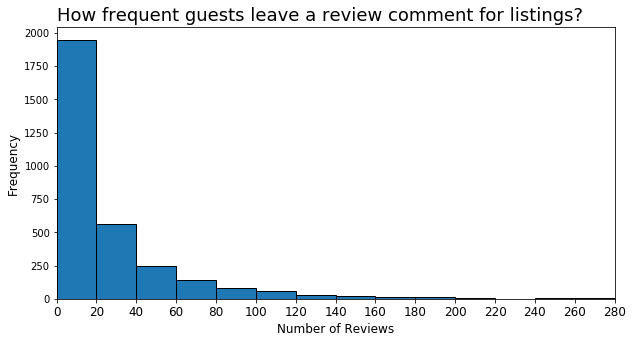

In [498]:
# to make a histogram of number of reviews per listings 
plt.figure(figsize=[10,5])

bin=np.arange(0,300,20)
plt.hist(df2['number_of_reviews'],bins=bin,edgecolor="k")
#df2['number_of_reviews'].max()
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(bin, fontsize=12)
plt.xlim(0,280)
plt.title('How frequent guests leave a review comment for listings?',loc='left',fontsize=18)
plt.show
plt.savefig('/Users/hmohamadi/Desktop/seattle/number_of_reviews_hist.png') # save as png


<function matplotlib.pyplot.show(*args, **kw)>

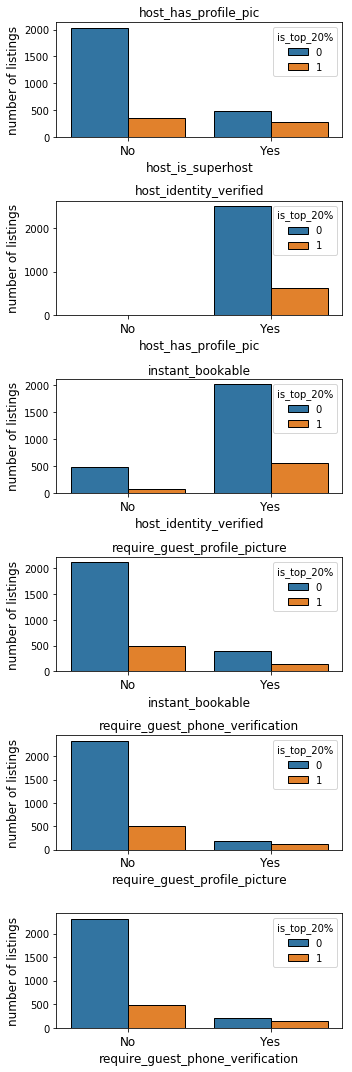

In [511]:
# to check which parameter impacts the number of reviews (being in top 20%) from boolean list
plt.figure(figsize=[5,15])
i=0

for col in boolean_list:
    plt.subplots_adjust(hspace = 0.3)
    i+=1
    plt.title(col)
    plt.subplot(len(boolean_list),1,i)
    figure=sns.countplot(x=col,hue='is_top_20%',data=df2,edgecolor="k")
    plt.xticks(np.arange(2),('No','Yes'),fontsize=12)
    plt.xlabel(col,fontsize=12)
    plt.yticks(fontsize=10)
    plt.ylabel('number of listings', fontsize=12)
    plt.tight_layout()


plt.show
#plt.savefig('/Users/hmohamadi/Desktop/seattle/host_data.png') # save as png



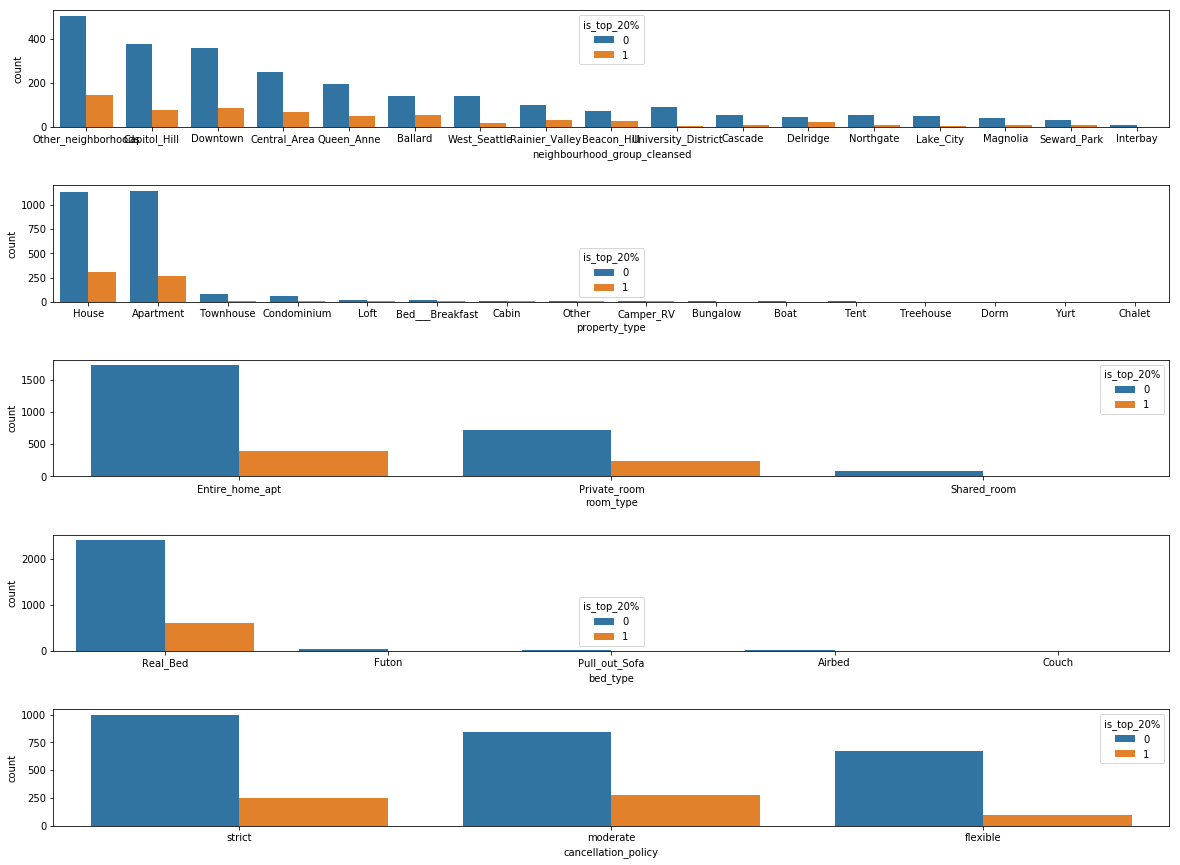

In [514]:
# to check which parameter impacts the number of reviews (being in top 20%) from categorical list

plt.figure(figsize=[20,15])
i=0
base_color = sns.color_palette()[0]

for col in categorical_list:
    plt.subplots_adjust(hspace = 0.5)
    i+=1
    plt.subplot(len(categorical_list),1,i)
    fig=sns.countplot(x=col,data=df2,hue='is_top_20%',order=df2[col].value_counts().index)#,hue='is_top_20%'


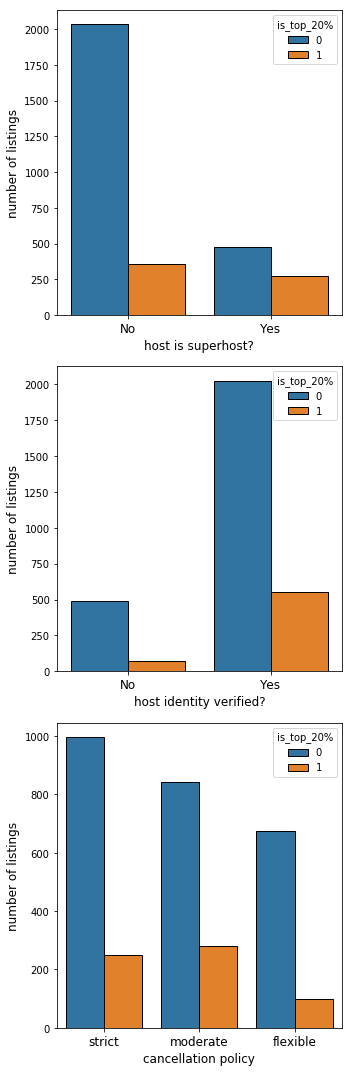

In [517]:
#to make specific graphs for most impactful parameters
plt.figure(figsize=[5,15])

plt.subplots_adjust(hspace = 0.3)
col='host_is_superhost'
plt.subplot(3,1,1)
figure=sns.countplot(x=col,hue='is_top_20%',data=df2,edgecolor="k")
plt.xticks(np.arange(2),('No','Yes'),fontsize=12)
plt.xlabel('host is superhost?',fontsize=12)
plt.yticks(fontsize=10)
plt.ylabel('number of listings', fontsize=12)
plt.tight_layout()

col='host_identity_verified'
plt.subplot(3,1,2)
figure=sns.countplot(x=col,hue='is_top_20%',data=df2,edgecolor="k")
plt.xticks(np.arange(2),('No','Yes'),fontsize=12)
plt.xlabel('host identity verified?',fontsize=12)
plt.yticks(fontsize=10)
plt.ylabel('number of listings', fontsize=12)
plt.tight_layout()


col='cancellation_policy'
plt.subplot(3,1,3)
figure=sns.countplot(x=col,hue='is_top_20%',data=df2,edgecolor="k",order=df2[col].value_counts().index)
#fig=sns.countplot(x=col,data=df2,,hue='is_top_20%',color=base_color)#,hue='is_top_20%'
plt.xticks(fontsize=12)
plt.xlabel('cancellation policy',fontsize=12)
plt.yticks(fontsize=10)
plt.ylabel('number of listings', fontsize=12)
plt.tight_layout()

df3=df2.groupby(['cancellation_policy','is_top_20%']).count()['id']/df2.groupby(['cancellation_policy']).count()['id']

plt.show
plt.savefig('/Users/hmohamadi/Desktop/seattle/host_data.png') # save as png



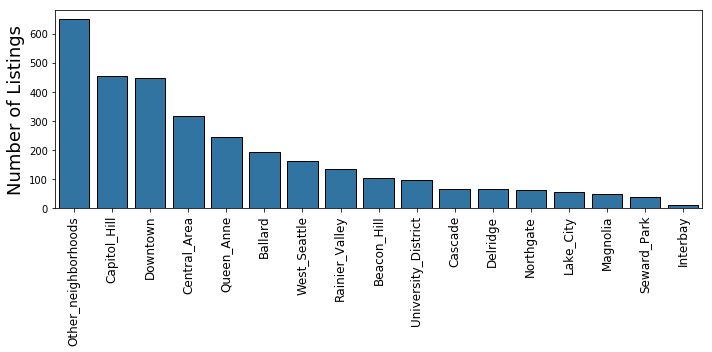

In [350]:
#to check number of listings in different areas
col='neighbourhood_group_cleansed'
plt.figure(figsize=[10,5])
base_color = sns.color_palette()[0]
fig=sns.countplot(x=col,data=df2,order=df2[col].value_counts().index,color=base_color,edgecolor="k")#,hue='is_top_20%'

plt.xticks(rotation=90,fontsize=12)
plt.xlabel('')
plt.ylabel('Number of Listings',fontsize=18)
plt.tight_layout()

plt.savefig('/Users/hmohamadi/Desktop/seattle/neighbourhood_count.png') # save as png


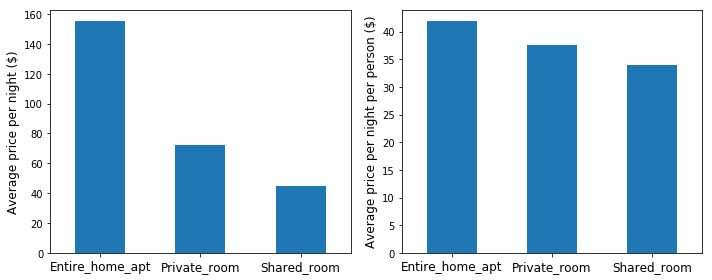

In [534]:
#to check price in differnt room types
col='room_type'
plt.figure(figsize=[10,4])
base_color = sns.color_palette()[0]
df_graph1=df2.groupby(col).mean()['price']
df_graph2=df2.groupby(col).mean()['price_per_person']
plt.subplot(1,2,1)
df_graph1.plot.bar(color=base_color)
plt.xticks(rotation=0,fontsize=12)
plt.xlabel('')
plt.ylabel('Average price per night ($)',fontsize=12)
plt.tight_layout()

plt.subplot(1,2,2)
df_graph2.plot.bar(color=base_color)
plt.xticks(rotation=0,fontsize=12)
plt.xlabel('')
plt.ylabel('Average price per night per person ($)',fontsize=12)
plt.tight_layout()

plt.savefig('/Users/hmohamadi/Desktop/seattle/roomtype_price.png') # save as png


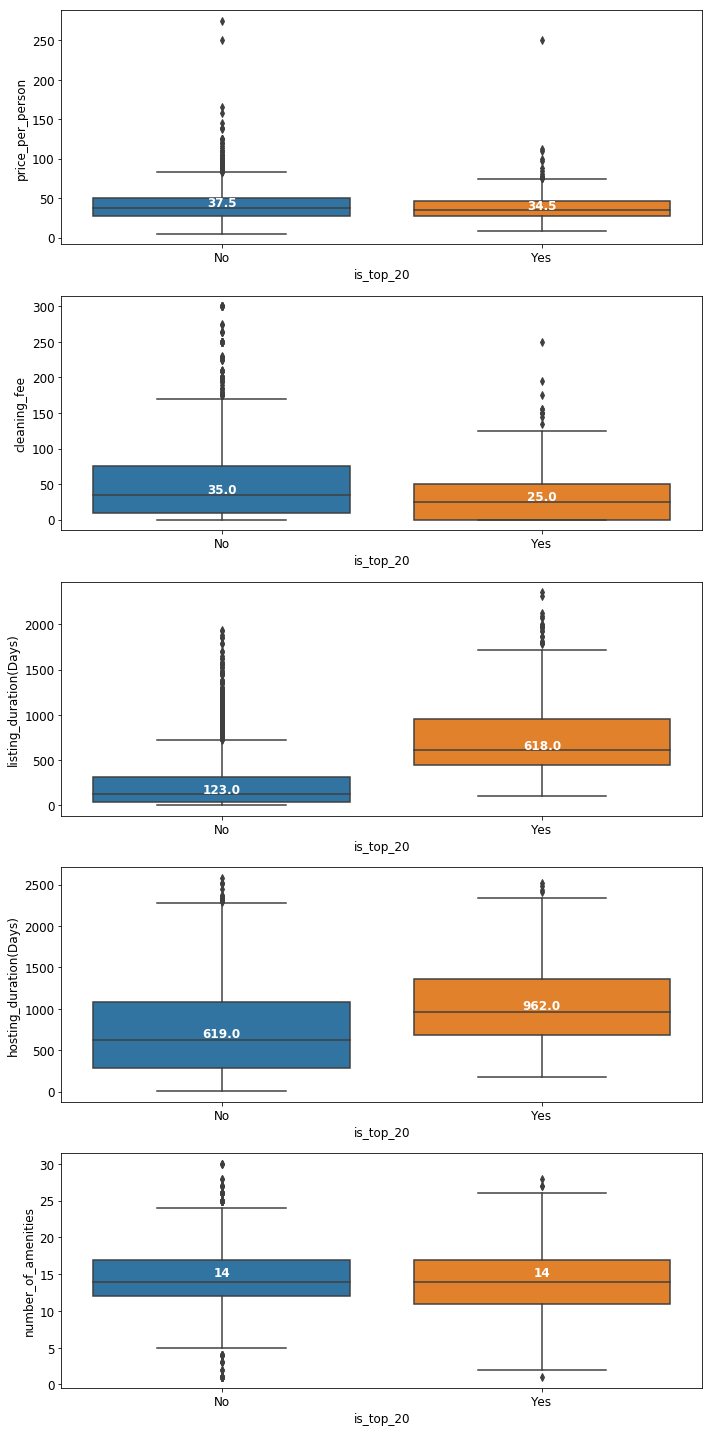

In [546]:
continous_list=['price_per_person','cleaning_fee','listing_duration(Days)', 
                'hosting_duration(Days)','number_of_amenities']
plt.figure(figsize=[10,20])
i=0
for col in continous_list:
    plt.subplots_adjust(hspace = 0.3)
    i+=1
    fig=plt.subplot(len(continous_list),1,i)
    figure=sns.boxplot(x='is_top_20%',y=col,data=df2)
    plt.xticks(np.arange(2),('No','Yes'),fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('is_top_20',fontsize=12)
    plt.ylabel(col,fontsize=12)
    medians = df2.groupby('is_top_20%').median()[col]
    vertical_offset = df2[col].median() * 0.05 # offset from median for display
    for xtick in figure.get_xticks():
        figure.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
        horizontalalignment='center',size='x-small',color='w',weight='semibold',fontsize=12)
    plt.tight_layout()

plt.savefig('/Users/hmohamadi/Desktop/seattle/continous.png') # save as png


<function matplotlib.pyplot.show(*args, **kw)>

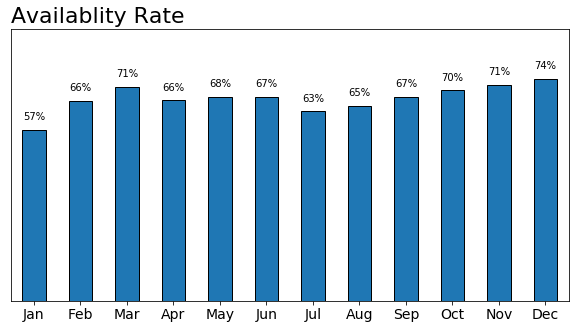

In [147]:
#to calculate availabity rate from calendar dataset and identify the busiest months
df_calendar['price_num']=np.vectorize(convert_currency_number)(df_calendar['price']).astype(float)
df_calendar_available=df_calendar.copy()
df_calendar_available.dropna(subset=['price_num'],how='any',axis=0,inplace=True)
df_calendar2=pd.DataFrame()
df_calendar.loc[:,'month']=df_calendar.loc[:,'date'].str[5:7]
df_calendar2['meanPrice']=df_calendar_available.groupby(['month']).mean()['price_num']
df_calendar2['percentageTotal']=(df_calendar_available.groupby('month').count()['price_num'])/(df_calendar.groupby('month').count()['listing_id'])*100

plt.figure(figsize=[10,5])
base_color = sns.color_palette()[0]

df_calendar2['percentageTotal'].plot.bar(color=base_color,edgecolor="k")
plt.xticks(np.arange(12),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'),rotation=0,fontsize=14)
plt.yticks([])
plt.title('Availablity Rate',loc='left',fontsize=22)
plt.xlabel('')
plt.ylim(0,90)
for x,y in zip(np.arange(0,12,1),df_calendar2['percentageTotal']):

    label = ("{:.0f}"+"%").format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('/Users/hmohamadi/Desktop/seattle/Availabity_Rate.png') # save as png

plt.show


<function matplotlib.pyplot.show(*args, **kw)>

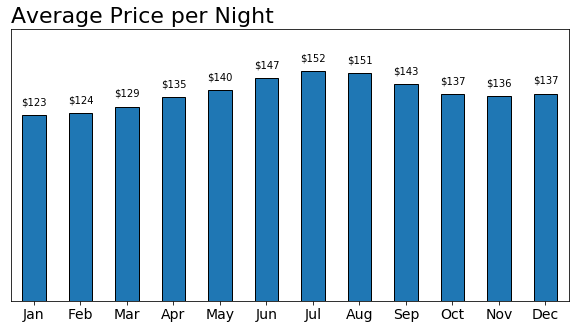

In [152]:
#to calculate average price per night from calendar dataset and identify price change over a year
plt.figure(figsize=[10,5])
base_color = sns.color_palette()[0]

df_calendar2['meanPrice'].plot.bar(color=base_color,edgecolor="k")
plt.xticks(np.arange(12),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'),rotation=0,fontsize=14)
plt.yticks([])
plt.title('Average Price per Night',loc='left',fontsize=22)
plt.xlabel('')
plt.ylim(0,180)
for x,y in zip(np.arange(0,12,1),df_calendar2['meanPrice']):

    label = ("$"+"{:.0f}").format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('/Users/hmohamadi/Desktop/seattle/Mean_price.png') # save as png

plt.show


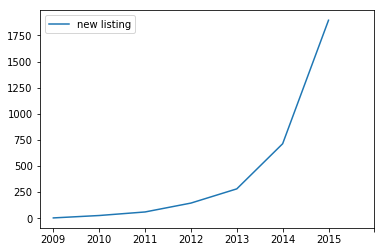

In [451]:
#number of listings trend over time
df_origianl_clean.loc[:,'host_since_monthyear']=df_origianl_clean.loc[:,'host_since'].str[0:4]
df_origianl_clean.loc[:,'listing_since_monthyear']=df_origianl_clean.loc[:,'first_review'].str[0:4]
df_origianl_clean2=pd.DataFrame()
#df_origianl_clean2['new hosts']=df_origianl_clean.groupby(['host_since_monthyear']).count()['id']
df_origianl_clean2['new listing']=df_origianl_clean.groupby('listing_since_monthyear').count()['id']
df_origianl_clean2.fillna(0,inplace=True)
df_origianl_clean2[:-1].plot()
plt.xticks(np.arange(8), ('2009', '2010', '2011', '2012','2013','2014','2015'))
plt.xticks(np.arange(0, len(df_origianl_clean2), 1.0))
plt.xlabel('')

plt.savefig('/Users/hmohamadi/Desktop/seattle/Trends.png') # save as png
plt.show()


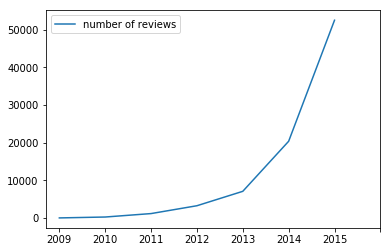

In [458]:
#number of reviews over time
df_reviews.loc[:,'date_year']=df_reviews.loc[:,'date'].str[0:4]
df_review2=pd.DataFrame()
df_review2['number of reviews']=df_reviews.groupby('date_year').count()['id']
df_review2.fillna(0,inplace=True)
df_review2[:-1].plot()
plt.xticks(np.arange(8), ('2009', '2010', '2011', '2012','2013','2014','2015'))
plt.xticks(np.arange(0, len(df_origianl_clean2), 1.0))
plt.xlabel('')

plt.savefig('/Users/hmohamadi/Desktop/seattle/Trends-reviews.png') # save as png
plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

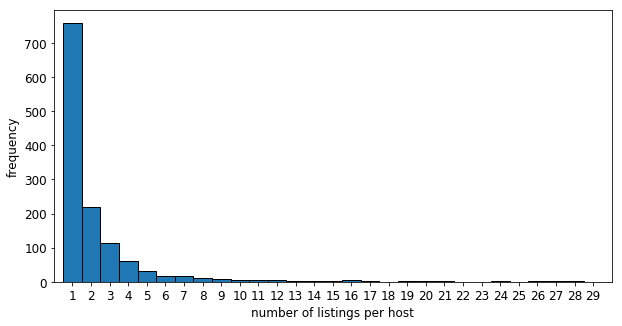

In [490]:
#number of listings per hosts
plt.figure(figsize=[10,5])
bins=np.arange(0,30)
plt.hist(df_origianl_clean.groupby(['host_name']).count()['id'],bins=bins,align='left',edgecolor='k')
plt.xticks(np.arange(1,30),fontsize=12)
plt.xlabel('number of listings per host',fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('frequency',fontsize=12)
plt.xlim(0,30)
plt.savefig('/Users/hmohamadi/Desktop/seattle/listing_per_host.png') # save as png

plt.show


In [ ]:
#cleaned daraframe with categorical data in original form
df_origianl_clean=df2.drop(['number_of_reviews'],axis=1)

#cleaned daraframe with categorical data converted to dummies
Dummy_df=pd.get_dummies(df2[categorical_list], prefix=categorical_list, prefix_sep='_', drop_first=True)
without_dummy_df=df2.copy()
for col in categorical_list:
    without_dummy_df.drop(col, axis=1,inplace=True)
    
df_dummy_clean = pd.concat([without_dummy_df, Dummy_df], axis=1)


In [ ]:
df_model=df_dummy_clean.drop(['id','last_scraped','host_name','host_since','host_location','host_about'
                     ,'neighbourhood_cleansed','latitude','longitude','amenities','first_review','last_review'],axis=1)#,inplace=True)
X=df_model.drop(['is_top_20%'],axis=1)
y=df_model['is_top_20%']                         
                              
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
lr_model=LogisticRegression() 
lr_model.fit(X_train,y_train)
y_test_preds = lr_model.predict(X_test)
print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) #met